# Estimating Groundwater Elevation with Machine Learning

# Sections:

1. Introduction

    - Proposal

    - Data

2. Methods

    - Preprocessing

    - Exploratory Data Analysis

        - Correlation Matrix

        - Visualize Data

    - Modeling

        - Linear Regression

            - Single

            - Multiple

        - Random Forest

            - Hyperparameter Optimization
            
            - Test Model

3. Results

5. Discussion



# Introduction

## Proposal:

The general risks sea-level rise poses on society are generally well known; however one risk is often overlooked, the risk of groundwater contamination due to encroaching seawater. Groundwater supplies almost half of all drinking water and agriculture around the globe. Creating a trend analysis of groundwater quality and quantity can help us better understand the risks of sea-level rise on groundwater quality and how to mitigate them. With available sampling data a trend analysis can be created to determine if there is a detectable effect of sea-level rise on groundwater quality and quantity.

As water levels change, the quality of the water changes, so normalization of chemical concentrations by groundwater level is desired to compare the data overtime and across different locations. So, one part of this process is being able to normalize chemical concentrations with groundwater levels. One caveat to this is that often sampling data does not have associated groundwater depth information.

The main goal of this project is to see if it is possible to predict the groundwater level based on the date a sample was taken, observed, precipitation, and temperatures. If this proves effective at predicting groundwater levels, then it may be sufficient in normalizing chemical concentrations to create a trend analysis of groundwater quality.

## Data:

For this project I will require groundwater depth data at monitoring wells, their locations, elevations, observed precipitation, minimum and maximum temperatures. I am familiar with some of the datasets, so I know that there is sufficient for the Los Angeles area. The monitoring well data is downloaded from GeoTracker, the California Water Boards' data management system. They store their data by county and have the data required stored in different datasets. This includes the latitudes, longitudes and elevations as well as groundwater depth measurements. The precipitation and temperature data are downloaded from the National Oceanic and Atmospheric Administration (NOAA) and is stored in a csv file. The data is stored by date and location. The data is available from 2000 to 2022. Using the search tool on the NOAA website I found the closest weather station to the monitoring wells, in this case the weather station at USC.  The data is stored in a csv file and includes the date, precipitation, minimum and maximum temperatures.

[GeoTracker Data by County:](https://geotracker.waterboards.ca.gov/data_download_by_county)

- [Well Locations](https://geotracker.waterboards.ca.gov/data_download/geo_by_county/LosAngelesGeoXY.zip)

- [Well Elevation](https://geotracker.waterboards.ca.gov/data_download/geo_by_county/LosAngelesGeoZ.zip)

- [Depth to Water Table](https://geotracker.waterboards.ca.gov/data_download/geo_by_county/LosAngelesGeoWell.zip)

[NOAA  National Centers for Environmental Information:](https://www.ncdc.noaa.gov/cdo-web/datasets)

- [Daily Summaries - USC Weather Observations](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/daily/by_station/USW00093134.csv.gz)



# Methods

## Preprocessing

Because the well data is stored in different datasets, I need to load and clean each dataset separately, modify the formats of column names and values to be consistent across the different datasets. This includes creating a well ID (WID) column, consolidating depth values into one column, dropping rows missing required data. I will also create z-score columns for both depth and water elevation. I will remove any rows where the absolute z score of either value is above 3. This is to remove any outliers in the data. I also need to merge the datasets together to create a single dataframe. I will also need to clean the weather data to remove any missing values and convert the date column to a datetime object.

#### Packages

In [266]:
import pandas as pd
import numpy as np
from datetime import date
import scipy.stats as stats

#### Functions

In [267]:
# Create well ID (WID) column.
def create_WID(df, col_name):
    
    df['WID'] = df['GLOBAL_ID'] + '-' + df[col_name]
    return df


# Create date column for weather data.
def get_date(row):

    string = str(row['DATE'])

    year = string[:4]
    month = string[4:6]
    day = string[6:]

    date = year + '-' + month + '-' + day

    return date

### Load and Clean Data

#### Geotracker Depth to Groundwater

In [268]:
# Load depth to groundwater data
geo_well = pd.read_csv('data/LosAngelesGeoWell.txt', sep='\t', encoding='unicode_escape')

# Convert date to datetime
geo_well['GW_MEAS_DATE'] = pd.to_datetime(geo_well['GW_MEAS_DATE'],format='%Y-%m-%d', errors='coerce')

# Create a mask for any rows with dates past the current date and drop them.
mask = geo_well['GW_MEAS_DATE'] >= str(date.today())
geo_well = geo_well[~mask]

# Create a mask for any rows with dates before the specified date (01-01-2000) and drop them.
mask = geo_well['GW_MEAS_DATE'] <= '01-01-2000'
geo_well = geo_well[~mask]

# Drop any rows with null values for GW_MEAS_DATE and reset the index.
geo_well.dropna(subset=['GW_MEAS_DATE'], inplace=True)
geo_well.reset_index(drop=True, inplace=True)

# Fill NaNs with 0 for the DTFPROD and DTW columns.
geo_well['DTFPROD'].fillna(0, inplace=True)
geo_well['DTW'].fillna(0, inplace=True)

# Create a new column for the total depth to groundwater.
geo_well['DEPTH'] = np.nan

# Create mask for rows with DTFPROD == 0 then sets DEPTH equal to DTW.
mask = geo_well['DTFPROD'] == 0
geo_well.loc[mask, 'DEPTH'] = geo_well['DTW']

# Create maks for rows with DTW == 0 then sets DEPTH equal to DTFPROD.
mask = geo_well['DTW'] == 0
geo_well.loc[mask, 'DEPTH'] = geo_well['DTFPROD']

# Create a mask for rows with DTFPROD != 0 and DTW != 0 then sets DEPTH equal to DTW.
mask = (geo_well['DTW'] != 0) & (geo_well['DTFPROD'] != 0)
geo_well.loc[mask, 'DEPTH'] = geo_well['DTW']

# Create mask for rows with depth of 0 and drop them.
mask = geo_well['DEPTH'] == 0
geo_well = geo_well[~mask]

# Create a WID column.
geo_well = create_WID(geo_well, 'FIELD_POINT_NAME')
geo_well['GID'] = geo_well['WID'] + ':' + geo_well['GW_MEAS_DATE'].astype(str)

c:\Users\chief\.conda\envs\geoprj\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (3,4,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Geotracker Well Elevation

In [269]:
# Load the top of well elevation data.
geo_z = pd.read_csv('data/LosAngelesGeoZ.txt', sep='\t', encoding='unicode_escape', on_bad_lines='warn')

# Fill in NaN values with 0
geo_z['RISER_HT'].fillna(0, inplace=True)

# Remove invalid rows
geo_z.drop(geo_z[geo_z['RISER_HT'] == '2009-12-18'].index, inplace=True)

# Add RISER_HT to the ELEVATION column to get true well casing elevation (where depth to water is measured from).
geo_z['ELEVATION'] = geo_z['ELEVATION'] + geo_z['RISER_HT'].astype(float)

# Remove rows with invalid ELEVATION values
geo_z.dropna(subset=['ELEVATION'], inplace=True)

# Create WID column.
geo_z = create_WID(geo_z, 'FIELD_PT_NAME')

# Keep only requied columns.
geo_z = geo_z[['WID', 'ELEVATION']]

b'Skipping line 211619: expected 12 fields, saw 20\n'
c:\Users\chief\.conda\envs\geoprj\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (2,5,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Geotracker Well XY

In [270]:
# Load the well location data.
geo_xy = pd.read_csv('data/LosAngelesGeoXY.txt', sep='\t', encoding='unicode_escape', on_bad_lines='warn')

# Create WID column.
geo_xy = create_WID(geo_xy, 'FIELD_PT_NAME')

# Create mask for rows with NaN X and Y values and drop them.
mask = (geo_xy['LATITUDE'].isna()) | (geo_xy['LONGITUDE'].isna())
geo_xy = geo_xy[~mask]

# Create mask for rows with latitude and longitude in NAD83 and keep them.
mask = geo_xy['XY_DATUM'] == 'NAD83'
geo_xy = geo_xy[mask]

# Reset the index.
geo_xy.reset_index(drop=True, inplace=True)

# Keep only required columns.
geo_xy = geo_xy[['WID', 'LONGITUDE', 'LATITUDE']]

b'Skipping line 18923: expected 13 fields, saw 14\nSkipping line 19016: expected 13 fields, saw 14\n'
b'Skipping line 200273: expected 13 fields, saw 14\nSkipping line 200274: expected 13 fields, saw 14\nSkipping line 200275: expected 13 fields, saw 14\nSkipping line 200444: expected 13 fields, saw 14\nSkipping line 200445: expected 13 fields, saw 14\nSkipping line 200446: expected 13 fields, saw 14\nSkipping line 201921: expected 13 fields, saw 14\nSkipping line 201922: expected 13 fields, saw 14\nSkipping line 202073: expected 13 fields, saw 14\nSkipping line 202074: expected 13 fields, saw 14\nSkipping line 202075: expected 13 fields, saw 14\nSkipping line 202076: expected 13 fields, saw 14\nSkipping line 202396: expected 13 fields, saw 14\nSkipping line 202660: expected 13 fields, saw 14\nSkipping line 202901: expected 13 fields, saw 14\nSkipping line 202902: expected 13 fields, saw 14\nSkipping line 205043: expected 13 fields, saw 14\nSkipping line 205044: expected 13 fields, saw 

#### Los Angeles USC Weather Station Data

In [271]:
# Load the weather data.
weather = pd.read_csv('data/USW00093134.csv', engine='python')

# Create a string date column.
weather['S_DATE'] = weather.apply(get_date, axis=1)

# Fix date column using pandas' to_datetime function and the string date.
weather['DATE'] = pd.to_datetime(weather['S_DATE'])

# Keep only required columns.
weather =  weather[['DATE', 'ELEMENT', 'DATA_VALUE']]

# Create mask for the types of weather data we want to keep, i.e. precipitation, min and max temperature.
mask = (weather['ELEMENT'] == 'TMAX') | (weather['ELEMENT'] == 'TMIN') | (weather['ELEMENT'] == 'PRCP')

# Create pivot table for the weather data types, each row is a date and each column is a weather data type.
pivot = weather[mask].pivot_table(index='DATE', columns='ELEMENT', values='DATA_VALUE')

# Drop rows with NaN values and reset the index.
pivot.dropna(inplace=True)
pivot.reset_index(inplace=True)

In [272]:
# Load the well location data.
geo_xy = pd.read_csv('data/LosAngelesGeoXY.txt', sep='\t', encoding='unicode_escape', on_bad_lines='warn')

# Create WID column.
geo_xy = create_WID(geo_xy, 'FIELD_PT_NAME')

# Create mask for rows with NaN X and Y values and drop them.
mask = (geo_xy['LATITUDE'].isna()) | (geo_xy['LONGITUDE'].isna())
geo_xy = geo_xy[~mask]

# Create mask for rows with latitude and longitude in NAD83 and keep them.
mask = geo_xy['XY_DATUM'] == 'NAD83'
geo_xy = geo_xy[mask]

# Reset the index.
geo_xy.reset_index(drop=True, inplace=True)

# Keep only required columns.
geo_xy = geo_xy[['WID', 'LONGITUDE', 'LATITUDE']]

b'Skipping line 18923: expected 13 fields, saw 14\nSkipping line 19016: expected 13 fields, saw 14\n'
b'Skipping line 200273: expected 13 fields, saw 14\nSkipping line 200274: expected 13 fields, saw 14\nSkipping line 200275: expected 13 fields, saw 14\nSkipping line 200444: expected 13 fields, saw 14\nSkipping line 200445: expected 13 fields, saw 14\nSkipping line 200446: expected 13 fields, saw 14\nSkipping line 201921: expected 13 fields, saw 14\nSkipping line 201922: expected 13 fields, saw 14\nSkipping line 202073: expected 13 fields, saw 14\nSkipping line 202074: expected 13 fields, saw 14\nSkipping line 202075: expected 13 fields, saw 14\nSkipping line 202076: expected 13 fields, saw 14\nSkipping line 202396: expected 13 fields, saw 14\nSkipping line 202660: expected 13 fields, saw 14\nSkipping line 202901: expected 13 fields, saw 14\nSkipping line 202902: expected 13 fields, saw 14\nSkipping line 205043: expected 13 fields, saw 14\nSkipping line 205044: expected 13 fields, saw 

### Merge Data

In [273]:
# Create Pandas dataframe for the well data by merging the depth to water and well elevation data.
geo = pd.merge(geo_well, geo_z, on='WID', how='left')

# Merge the well data with the xy data.
geo = pd.merge(geo, geo_xy, on='WID', how='left')

# Merge the well data with the weather data.
geo = pd.merge(geo, pivot, left_on='GW_MEAS_DATE', right_on='DATE', how='left')

# Drop NaNs from the ELEVATION column.
geo.dropna(subset=['ELEVATION'], inplace=True)

# Keep only rows where depth is greater than 0. Cannot have negative depth.
geo = geo[geo.loc[:,'DEPTH'] >= 0]

# Drop duplicate GID rows.
geo.drop_duplicates(subset=['GID'], inplace=True)

# Create WATER_ELEVATION column by subtracting the the depth to water from the well elevation.
geo['WATER_ELEVATION'] = geo['ELEVATION'] - geo['DEPTH']

# Drop NaNs from the WATER_ELEVATION, LATIDUTE, and LONGITUDE columns.
geo.dropna(subset=['WATER_ELEVATION','LATITUDE','LONGITUDE'], inplace=True)

# Sort values by date and then reset the index.
geo.sort_values(by=['GW_MEAS_DATE'], inplace=True)

# Create ZSCORE columns for DEPTH and WATER_ELEVATION and use them to remove outliers.
geo['ZSCORE_DEPTH'] =  stats.zscore(geo['DEPTH'])
geo['ZSCORE_WELEV'] =  stats.zscore(geo['WATER_ELEVATION'])

# Create a mask for rows with ZSCORE_DEPTH > 3 or ZSCORE_WELEV > 3 and drop them, then reset the index.
mask = (abs(geo['ZSCORE_WELEV']) >= 3)
geo = geo[~mask]
geo.reset_index(drop=True, inplace=True)

### Export Data

In [274]:
# Define columns to keep.
cols = ['WID', 'GW_MEAS_DATE', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'ELEVATION', 'WATER_ELEVATION',  'PRCP', 'TMAX', 'TMIN']

# Save only the required columns to a csv file.
geo[cols].to_csv('data/full.csv', index=False)

## Exploratory Data Analysis

The first step of my analysis to explore and visualize the data. I will start by creating a correlation matrix to see if there are any strong correlations between the variables. I will then visualize the data to see if there are any trends in the data. I will also plot the well locations on a map to see if there are any trends in the data based on location like clustering.

#### Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

#### Data

In [238]:
data = pd.read_csv(r'data\full.csv')
data.loc[:,'GW_MEAS_DATE'] = pd.to_datetime(data['GW_MEAS_DATE'])

bounds = gpd.read_file(r'data\County_Boundaries\County_Boundaries.shp')
la = bounds[bounds['TYPE'] == 'LA County'].reset_index(drop=True)
la.loc[:,'geometry'] = la['geometry'].to_crs(epsg=4326)

### Correlation Matrix

In [278]:
data_mod = data.copy()

data_mod['GW_MEAS_DATE'] = pd.to_numeric(data_mod['GW_MEAS_DATE'])

In [279]:
data_mod.corr()

,GW_MEAS_DATE,LATITUDE,LONGITUDE,DEPTH,ELEVATION,WATER_ELEVATION,PRCP,TMAX,TMIN
GW_MEAS_DATE,1.000000,-0.056636,0.027512,0.161291,0.002025,-0.023715,-0.023666,0.064667,0.091953
LATITUDE,-0.056636,1.000000,-0.411282,0.249315,0.793708,0.775539,0.011609,-0.009512,-0.012915
LONGITUDE,0.027512,-0.411282,1.000000,-0.072435,-0.301970,-0.298642,-0.009726,-0.004076,-0.000693
DEPTH,0.161291,0.249315,-0.072435,1.000000,0.246540,0.093348,0.012301,0.005649,0.008867
ELEVATION,0.002025,0.793708,-0.301970,0.246540,1.000000,0.987915,0.007944,-0.004847,-0.006756
WATER_ELEVATION,-0.023715,0.775539,-0.298642,0.093348,0.987915,1.000000,0.006194,-0.005883,-0.008359
PRCP,-0.023666,0.011609,-0.009726,0.012301,0.007944,0.006194,1.000000,-0.235696,-0.101809
TMAX,0.064667,-0.009512,-0.004076,0.005649,-0.004847,-0.005883,-0.235696,1.000000,0.696918
TMIN,0.091953,-0.012915,-0.000693,0.008867,-0.006756,-0.008359,-0.101809,0.696918,1.000000


In the correlation matrix, we see that there are not any variables with a strong correlation to groundwater depth, but water elevation does have a strong positive correlation with latitude at 0.793708. The strongest correlation to depth is elevation of the well with a score of 0.246540. The rest of the variables have remarkably low correlation scores for what I would assume, considering these are the main factors that affect groundwater levels. This means a linear regression model may not be very effective at predicting groundwater levels.

### Visualizations

Here I want to visualize the data to see if there are any trends. I will start by plotting the groundwater depth and elevation over time. I will then plot the groundwater depth and elevation by latitude and longitude.

In [313]:
data = pd.read_csv(r'data\full.csv')
data.loc[:,'GW_MEAS_DATE'] = pd.to_datetime(data['GW_MEAS_DATE'])

#### Graphs

Text(0, 0.5, 'Water Elevation (ft)')

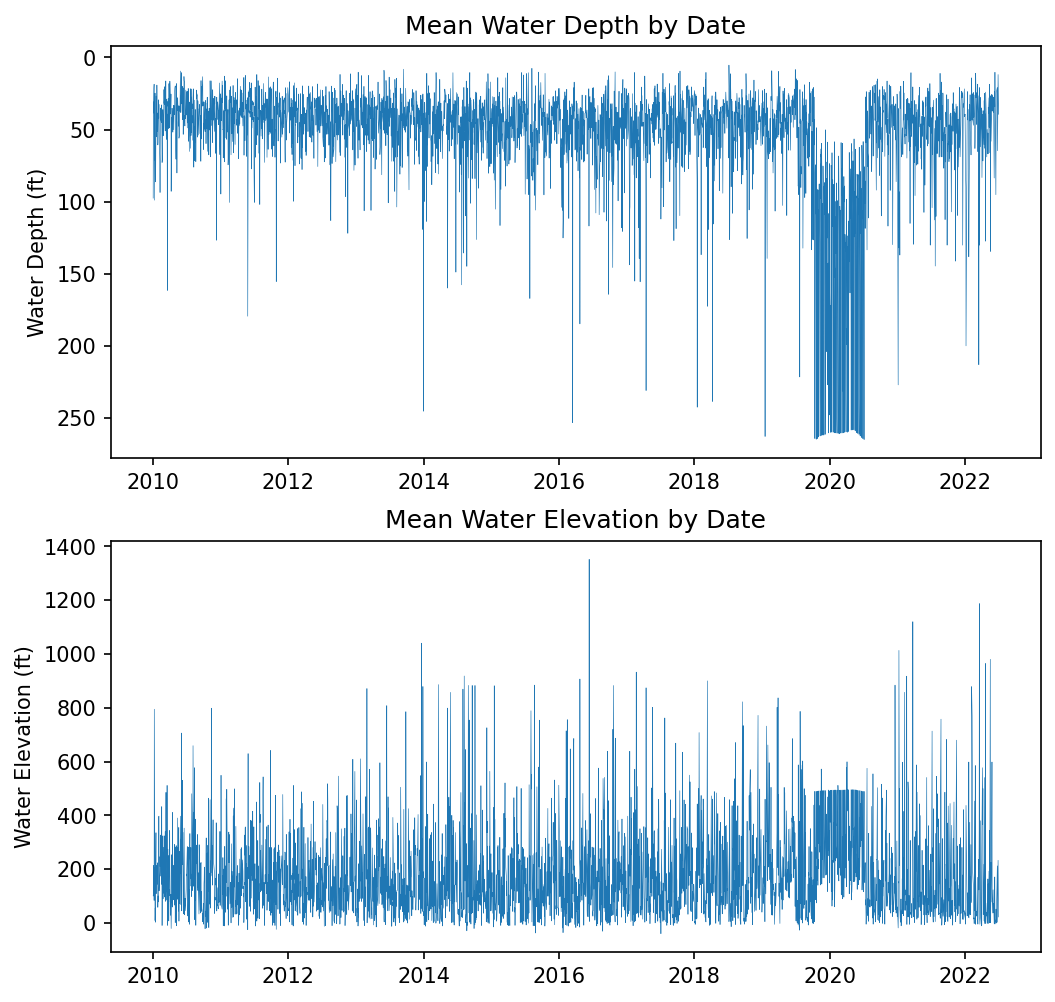

In [325]:
by_date = data.groupby(['GW_MEAS_DATE']).mean().reset_index()


date_chunk = by_date[(by_date['GW_MEAS_DATE'].dt.year >= 2010)] #& (by_date['GW_MEAS_DATE'].dt.year <= 2015)]

fig, ax = plt.subplots(2,1,figsize=(8,8), dpi=150)

ax[0].plot(date_chunk['GW_MEAS_DATE'], date_chunk['DEPTH'], linewidth=0.3)
ax[0].invert_yaxis()
ax[0].set_title('Mean Water Depth by Date')
ax[0].set_ylabel('Water Depth (ft)')

ax[1].plot(date_chunk['GW_MEAS_DATE'], date_chunk['WATER_ELEVATION'], linewidth=0.3)
ax[1].set_title('Mean Water Elevation by Date')
ax[1].set_ylabel('Water Elevation (ft)')


The graphs above show that there is not a strong trend in the data. The data is very noisy and there are no clear trends. There also seems to be some sort of anomaly in the data. Around 2020 there is a sudden drop in groundwater depth and increase in regularity in groundwater depth values. This is not a trend, but it is something to keep in mind when creating the model.

#### Well Locations

In [281]:
points = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LONGITUDE, data.LATITUDE))

la = la.iloc[0,5]
bounds = la.bounds
minx, miny, maxx, maxy = bounds
print(minx, miny, maxx, maxy)

points = points.loc[
    ((points['geometry'].x >= minx) & (points['geometry'].x <= maxx))
    &
    ((points['geometry'].y >= miny) & (points['geometry'].y <= maxy))
]

points = points.reset_index(drop=True)

-118.9446306258179 33.70366940378135 -117.64637387599747 34.82330642768978


C:\Users\chief\AppData\Local\Temp\ipykernel_3872\609258529.py:5: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in la:
C:\Users\chief\AppData\Local\Temp\ipykernel_3872\609258529.py:17: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in la:


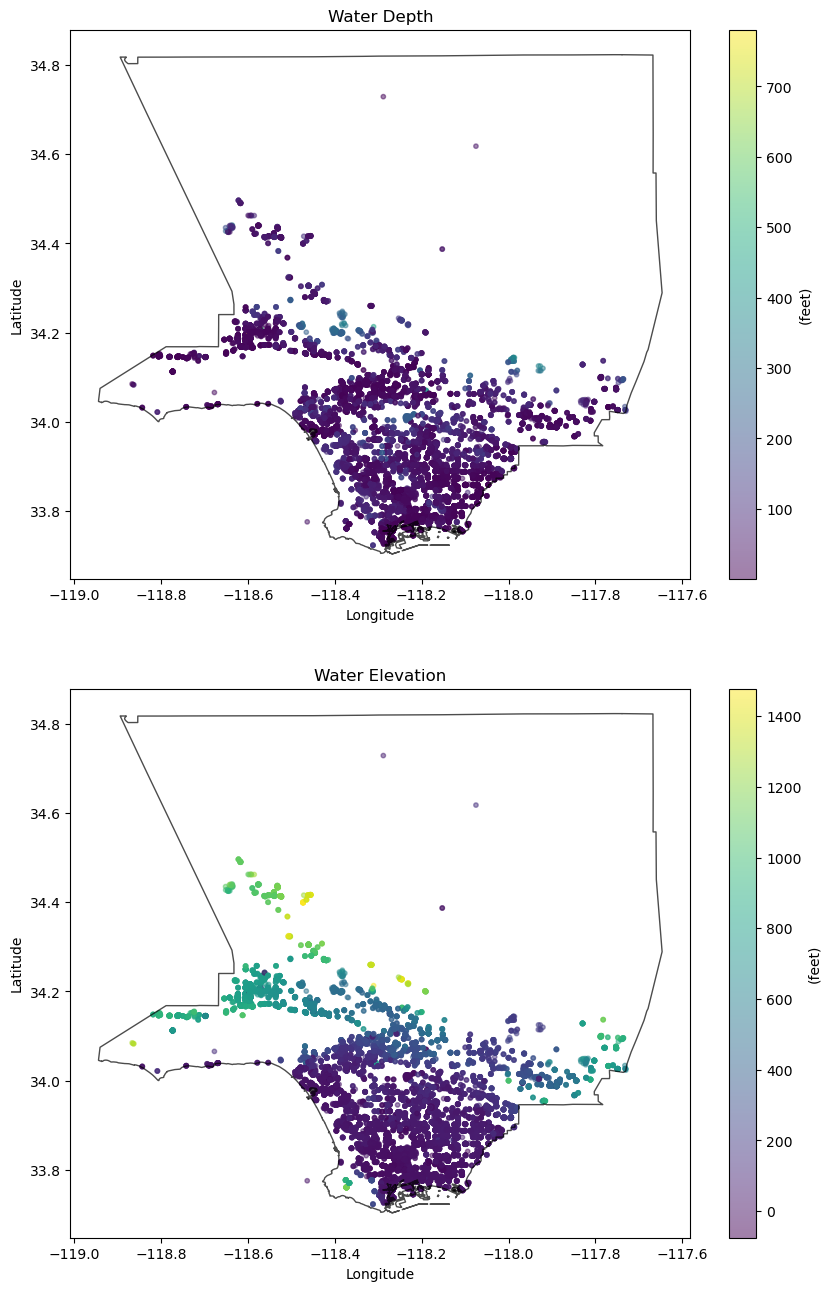

In [282]:
wells = points.groupby('WID').mean().reset_index()

fig, ax = plt.subplots(2,1,figsize=(10,16), dpi=100)

for polygon in la:
    x, y = polygon.exterior.xy
    ax[0].plot(x, y, color='black', alpha=0.7, linewidth=1, solid_capstyle='round')

s0 = ax[0].scatter(wells['LONGITUDE'], wells['LATITUDE'], c=wells['DEPTH'], cmap='viridis', marker='o', s=10, alpha=0.5)

plt.colorbar(s0, ax=ax[0], label='(feet)')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Water Depth')

for polygon in la:
    x, y = polygon.exterior.xy
    ax[1].plot(x, y, color='black', alpha=0.7, linewidth=1, solid_capstyle='round')

s1 = ax[1].scatter(wells['LONGITUDE'], wells['LATITUDE'], c=wells['WATER_ELEVATION'], cmap='viridis', marker='o', s=10, alpha=0.5)

plt.colorbar(s1, ax=ax[1], label='(feet)')


ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Water Elevation')

plt.show()

In the maps above we can see there is not much of a spatial trend in the depth data, but there is somewhat of a trend in the elevation data. The wells with the highest elevations are located in the northern part of the county. The wells with the lowest elevations are located in the southern part of the county. This is a relativly strong trend compared to our other variables and is something to keep in mind when creating the model.

## Modeling

In [287]:
data = pd.read_csv(r'data\fullcsv')
data.loc[:,'GW_MEAS_DATE'] = pd.to_numeric(pd.to_datetime(data['GW_MEAS_DATE']))

### Linear Regression

The first step in my modeling process will be to create a linear regression model. I will start by creating a single variable linear regression model and then a multiple variable linear regression model. I will then compare the results of the two models to see which one is more effective at predicting groundwater depth.

##### Packages

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import sklearn.metrics as metrics

#### Single Variable

In [290]:
x_train, x_test, y_train, y_test = ms.train_test_split(
                                data['GW_MEAS_DATE'], data['DEPTH'], test_size=0.2
                                )

# Load linear regression model.
model = lm.LinearRegression()

# Fit the model to the training data.
model.fit(x_train.to_numpy().reshape(-1,1), y_train)

# Predict the test data.
y_pred = model.predict(x_test.to_numpy().reshape(-1,1))

# Calculate the mean squared error.
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error.
rmse = np.sqrt(mse)


# Calculate the explained varience.
ev = metrics.explained_variance_score(y_test, y_pred)

print('Single Linear Regression: Depth')

print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Explained Variance: ', ev)

Single Linear Regression: Depth
Mean Squared Error:  1881.6450976179235
Root Mean Squared Error:  43.3779333027511
Explained Variance:  0.025323681388126573


In [291]:
x_train, x_test, y_train, y_test = ms.train_test_split(
                                data['GW_MEAS_DATE'], data['WATER_ELEVATION'], test_size=0.2
                                )

# Load linear regression model.
model = lm.LinearRegression()

# Fit the model to the training data.
model.fit(x_train.to_numpy().reshape(-1,1), y_train)

# Predict the test data.
y_pred = model.predict(x_test.to_numpy().reshape(-1,1))

# Calculate the mean squared error.
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error.
rmse = np.sqrt(mse)


# Calculate the explained varience.
ev = metrics.explained_variance_score(y_test, y_pred)

print('Single Linear Regression - Water Elevation')

print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Explained Variance: ', ev)

Single Linear Regression: Water Elevation
Mean Squared Error:  74877.59520266393
Root Mean Squared Error:  273.6377079327042
Explained Variance:  0.0004774100899234135


For the single linear regression looking at our main initial independent variable, measurement date, we see that the results are not very promising. The explained variance for both depth is 2% and for elevation is 0.04%. The root mean squared errors shows in feet how far on average the model is from the actual values. With a RMSE of 43 feet for the depth is not sufficient. This means that the model is not very effective at predicting groundwater depth or elevation.

#### Multiple Variable

The next step is to try a multiple variable linear regression model. I will use the same variables as the single variable model, but I will also add the precipitation, temperature and location data (longitude, latitude, elevation).

In [258]:
# Define x and y columns.
x_cols = ['GW_MEAS_DATE','LATITUDE','LONGITUDE', 'PRCP', 'TMAX', 'TMIN', 'ELEVATION']
y_cols = ['DEPTH', 'WATER_ELEVATION']

In [293]:
x_train, x_test, y_train, y_test = ms.train_test_split(
                                data[x_cols], data[y_cols[0]], test_size=0.2
                                )

# Load linear regression model.
model = lm.LinearRegression()

# Fit the model to the training data.
model.fit(x_train, y_train)

# Predict the test data.
y_pred = model.predict(x_test)

# Calculate the mean squared error.
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error.
rmse = np.sqrt(mse)


# Calculate the explained varience.
ev = metrics.explained_variance_score(y_test, y_pred)

print('Multiple Linear Regression - Depth')

print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Explained Variance: ', ev)

Multiple Linear Regression - Depth
Mean Squared Error:  1729.277260900681
Root Mean Squared Error:  41.58457960471262
Explained Variance:  0.08566603862622002


In [294]:
x_train, x_test, y_train, y_test = ms.train_test_split(
                                data[x_cols], data[y_cols[1]], test_size=0.2
                                )

# Load linear regression model.
model = lm.LinearRegression()

# Fit the model to the training data.
model.fit(x_train, y_train)

# Predict the test data.
y_pred = model.predict(x_test)

# Calculate the mean squared error.
mse = metrics.mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error.
rmse = np.sqrt(mse)


# Calculate the explained varience.
ev = metrics.explained_variance_score(y_test, y_pred)

print('Multiple Linear Regression - Water Elevation')

print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Explained Variance: ', ev)

Multiple Linear Regression - Water Elevation
Mean Squared Error:  1758.9418066285969
Root Mean Squared Error:  41.93974018313176
Explained Variance:  0.9766099731605342


We see above that the multiple linear regression for groundwater depth is not much better than the single linear regression performed previously. However, we see a marked improvement for groundwater elevation, bringing it more in line with the depth model, but with a much higher explained variance score of 97%. However, the RMSE for the depth model is 43 feet, meaning the model is still not very effective at predicting groundwater depth.

### Random Forest

While multiple linear regression was better overall compared to single, it still seems not explain as much of the variance as I would expect. My next option is to move to a different machine learning algorithm that will hopefully be more effective at predictions. I decided to use the random forest algorithm from sklearn as it seems like it would create a better model for the data, while not overfitting.

##### Packages

In [300]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import sklearn.model_selection as ms

##### Functions

Here I create some functions that I will use later to help optimze the random forest model.

In [297]:
def rfr_optimize(x,y,hyper_grid):
    '''
    This function is used to optimize the hyperparameters of the Random Forest Regressor.
    Input:
        x: independent variables
        y: dependent variable
        hyper_grid: a dictionary of hyperparameters and ranges to test for optimization
    '''

    # Split data into training and testing sets.
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2)

    # Create the model
    rfr = RandomForestRegressor(
        n_jobs=-1,
        verbose=1
        )

    # Create the grid search object
    grid = ms.GridSearchCV(
        rfr,
        hyper_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2,
        )

    # Perform grid search for optimal hyperparameter fit.
    grid.fit(x_train, y_train)
    
    return grid

In [298]:
def test_model(x,y,grid):

    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2)

    rfr = RandomForestRegressor(n_jobs=-1, **grid.best_params_)

    rfr.fit(x_train, y_train)

    y_pred = rfr.predict(x_test)

    print('Random Forest Regressor: ')
    print(grid.best_params_, '\n')

    evs = metrics.explained_variance_score(y_test, y_pred)
    print(f'Explained Variance: {evs}')

    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse}')
    

##### Data

Here I load the data and trim it to reduce the size. This is soley to help improve performance. I convert the date to a numeric and define the dependent and independent variables.

In [4]:
data = pd.read_csv(r'data\full.csv')

# Trim data by date to reduce size.
data = data[data['GW_MEAS_DATE'] > '2010-01-01'].reset_index(drop=True)

# Keep only water elevation data greater than 0.
data = data[data['WATER_ELEVATION'] >= 0].reset_index(drop=True)

# Date to numeric for modeling.
data['GW_MEAS_DATE'] = pd.to_numeric(pd.to_datetime(data['GW_MEAS_DATE']))

# Define x and y columns.
x_cols = ['GW_MEAS_DATE','LATITUDE','LONGITUDE', 'PRCP', 'TMAX', 'TMIN', 'ELEVATION']
y_cols = ['DEPTH', 'WATER_ELEVATION']


#### Default Random Forest Regressor

First, I will run a the default random forest regressor model to determine if it is worth optimizing.

In [34]:
# Split dataframe into x and y.
x = data[x_cols]
y = data[y_cols[1]]

x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2)

rfr = RandomForestRegressor(n_jobs=-1)

rfr.fit(x_train, y_train)

y_pred = rfr.predict(x_test)

print('Random Forest Regressor: ')
print('default','\n')

evs = metrics.explained_variance_score(y_test, y_pred)
print(f'Explained Variance: {evs}')

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Random Forest Regressor: 
default 

Explained Variance: 0.9999185860835155
Root Mean Squared Error: 2.630464109416857


The results here are very good. It may be worth optimizing the model to help avoid possible overfitting. The next step will be using cross validation to determine the best overall hyperparameters for the model.

#### Hyperparameter Optimization

In this section I will perform hyperparameter optimization on the random forest model. I will use the GridSearchCV function from sklearn to perform the optimization. First, I will run some fit tests on single hyperparameters to help find an effective range for each one. I will then run all combinations of the hyperparameter ranges in order to find the optimal values. I will also use 5-fold cross validation to determine the best hyperparameters.

In [295]:
# Split dataframe into x and y.
x = data[x_cols]
y = data[y_cols[1]]

##### Single Hyperarameter Optimization

##### bootstrap

In [301]:
bootstrap = ['True', 'False']

hyper_grid = {
    'bootstrap': bootstrap,
    }

grid = rfr_optimize(x,y,hyper_grid)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished


In [302]:
test_model(x,y,grid)

Random Forest Regressor: 
{'bootstrap': 'False'} 

Explained Variance: 0.9997994715615656
Root Mean Squared Error: 3.877695604064338


##### max_depth

In [303]:
max_depth = list(range(170, 200, 10))

hyper_grid = {
'max_depth': max_depth,
}

grid = rfr_optimize(x,y,hyper_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished


In [ ]:
test_model(x,y,grid)

The best fit for max_depth was 180

##### n_estimators

In [46]:
n_estimators = list(range(100, 200, 20))

hyper_grid = {
    'n_estimators': n_estimators,
    'max_depth': [180],
    }

grid = rfr_optimize(x,y,hyper_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   12.7s finished


In [47]:
test_model(x, y, grid)

Random Forest Regressor: 
{'max_depth': 180, 'n_estimators': 140} 

Explained Variance: 0.9999286470011867
Root Mean Squared Error: 2.483071787969361


##### min_samples_split

In [10]:
min_samples_split = list(range(5, 10, 1))

hyper_grid = {
    'min_samples_split': min_samples_split,
    'n_estimators': [140],
    'max_depth' : [180],
    }

grid = rfr_optimize(x,y,hyper_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   10.8s finished


In [11]:
test_model(x, y, grid)

Random Forest Regressor: 
{'max_depth': 180, 'min_samples_split': 5, 'n_estimators': 140} 

Explained Variance: 0.9999163985622394
Root Mean Squared Error: 2.661458208226467


##### min_samples_leaf

In [13]:
min_samples_leaf = list(range(1, 10, 2))

hyper_grid = {
    'n_estimators': [140],
    'max_depth' : [180],
    'min_samples_split': [5],
    'min_samples_leaf': min_samples_leaf,
    }

grid = rfr_optimize(x,y,hyper_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   10.7s finished


In [14]:
test_model(x, y, grid)

Random Forest Regressor: 
{'max_depth': 180, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 140} 

Explained Variance: 0.9999464595291411
Root Mean Squared Error: 2.127018156449179


Looking at the results above, I will take the best values for each hyperparameter and use them to create a grid of hyperparameters to test. There will be 3-5 values for each hyperparameter to test.

#### Multiple Hyperparameter Optimization

In [15]:
n_estimators = list(range(130,150,10))
max_depth = list(range(170,200,10))
min_samples_split = list(range(4,6,1))
min_samples_leaf = list(range(1, 4, 1))

hyper_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    }

grid = rfr_optimize(x,y,hyper_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   10.7s finished


In [17]:
test_model(x, y, grid)

Random Forest Regressor: 
{'max_depth': 180, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 130} 

Explained Variance: 0.9999108175582869
Root Mean Squared Error: 2.75540292324963


The results of the random forest model are very good. There is a large increase in performance over the linear models. The explained variance score for groundwater elevation model is 99.99% and the RMSE is 2.75 feet. This could be a very effective model for predicting groundwater elevation.

# Results

The overall results of the models are very interesting. The linear models performed much worse than expected, with the multiple linear regression model performing the best. The random forest model performed much better, with an explained variance score of 99.99% for groundwater elevation and RMSE of only 2.75 feet. This is a much better result that I had expected considering how poorly the linear models did compared to my expectations. Overall, I am quite pleased with the results of the random forest model. It could prove to be effective enough to be used in the real world for normalizing chemical concentrations in groundwater samples.

# Discussion

While the random forest model produced very good results, I do believe there is still room for improvement. One of the main issues is that the observed weather data is only coming from one station that can be quite far away from a sample location. This could be improved by using a more granular weather dataset. One possible dataset that was pointed out to me was the [Daymet data](https://daymet.ornl.gov/). It provides long-term, continuous, gridded estimates of daily weather and climatology. This could provide a more accurate measure of weather values for a specific location over a specific day. Another data point that may have value is information about the surficial geology of the area. This could provide information about the type of rock that the groundwater is flowing through. This could provide information about the porosity of the rock, which could be a factor in the groundwater levels. This could be a very useful data point for the model. Another possible improvement would be to use a different machine learning algorithm. I chose to use the random forest algorithm because it is a very effective algorithm for regression problems. However, there are other algorithms that may be more effective. One of these algorithms is the gradient boosting algorithm. This algorithm is very effective at regression problems and is often used in competitions. It may be worth trying this algorithm to see if it produces better results than the random forest algorithm. I would also like to try a neural network model as I haven't used one before and I think it would be a good learning experience. Overall, I am very pleased with the results of the random forest model. It is very effective at predicting groundwater elevation and could be used in the real world to normalize chemical concentrations in groundwater samples.

In the future the model could be trained on data across California to see if it could be used to predict groundwater elevation across the state. This would require a much larger dataset but could be very useful for groundwater managers, regulators and scientists alike.